# Metrics calculations


In [41]:
import warnings

import evaluate
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

In [2]:
MANUAL_SEED = 42

warnings.filterwarnings("ignore")

## Loading data

In [3]:
df = pd.read_csv("../data/raw/test.csv")
bart_df = pd.read_csv("../data/generated/bart.csv")
custom_transformer_df = pd.read_csv("../data/generated/custom_transformer.csv")

df["bart"] = bart_df["generated"]
df["custom_transformer"] = custom_transformer_df["generated"]
print(f"{len(df)=}")
df.head()

len(df)=500


,toxic,nontoxic,bart,custom_transformer
0,It's feeding time at the fucking zoo!,it's time to eat at the zoo!,it's feeding time at the zoo.,it 's about it and the floor.
1,Everyone here bet on the hero and lost their a...,they all took a hero and lost everything.,everyone here bet on him and they lost.,everyone 's here on your hero and all those th...
2,Then I got to come home to Melvin and his bull...,then I'm going home and Melvin's there.,then I have to come home to talk to Melvin.,then i have to come home and left his voice.
3,Sara here was hoping to pick your brains.,Sara was hoping you could handle her.,Sara here was hoping to pick your brains.,there was here i was hoping i 'd pick you your...
4,"Oh, that's stupid. If anyone wants to tell me ...","if anyone wants to tell me what's going on, I'...","if anyone wants to talk to me, I'll be in the ...",if anyone wants me to tell me what 's going on...


## Metrics

In [4]:
rouge_metric = evaluate.load("rouge")
meteor_metric = evaluate.load("meteor")
bleu_metric = evaluate.load("bleu")
wer_metric = evaluate.load("wer")

[nltk_data] Downloading package wordnet to D:\Code\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to D:\Code\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to D:\Code\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Using default facebook/roberta-hate-speech-dynabench-r4-target checkpoint


In [27]:
def compute_metrics(references, predictions, label: str):
    results = {
        "rouge1": [],
        "rouge2": [],
        "rougeL": [],
        "rougeLsum": [],
        "meteor": [],
        "bleu": [],
        "wer": [],
    }
    for ref, pred in tqdm(
        zip(references, predictions), total=len(references), desc=label
    ):
        ref = ref.strip().lower()
        pred = pred.strip().lower()
        metrics_rouge: dict = (
            rouge_metric.compute(predictions=[pred], references=[ref]) or {}
        )
        metrics_meteor: dict = (
            meteor_metric.compute(predictions=[pred], references=[ref]) or {}
        )
        metrics_bleu: dict = (
            bleu_metric.compute(predictions=[pred], references=[ref]) or {}
        )
        metrics_wer: float = wer_metric.compute(predictions=[pred], references=[ref])  # type: ignore

        results["rouge1"].append(metrics_rouge["rouge1"])
        results["rouge2"].append(metrics_rouge["rouge2"])
        results["rougeL"].append(metrics_rouge["rougeL"])
        results["rougeLsum"].append(metrics_rouge["rougeLsum"])

        results["meteor"].append(metrics_meteor["meteor"])
        results["bleu"].append(metrics_bleu["bleu"])
        results["wer"].append(metrics_wer)

    for k, v in results.items():
        results[k] = list(map(lambda x: round(x, 3), v))

    for k, v in results.items():
        print(f"{k}: {len(v)} ({v[:2]}...)")
    print()

    return results

In [28]:
bart_metrics = compute_metrics(df["nontoxic"], df["bart"], "bart")
custom_transformer_metrics = compute_metrics(
    df["nontoxic"], df["custom_transformer"], "custom_transformer"
)

bart: 100%|██████████| 500/500 [01:39<00:00,  5.01it/s]


rouge1: 500 ([0.8, 0.375]...)
rouge2: 500 ([0.462, 0.0]...)
rougeL: 500 ([0.8, 0.25]...)
rougeLsum: 500 ([0.8, 0.25]...)
meteor: 500 ([0.713, 0.222]...)
bleu: 500 ([0.0, 0.0]...)
wer: 500 ([0.571, 0.875]...)



custom_transformer: 100%|██████████| 500/500 [01:43<00:00,  4.84it/s]

rouge1: 500 ([0.4, 0.333]...)
rouge2: 500 ([0.154, 0.125]...)
rougeL: 500 ([0.4, 0.222]...)
rougeLsum: 500 ([0.4, 0.222]...)
meteor: 500 ([0.169, 0.343]...)
bleu: 500 ([0.0, 0.0]...)
wer: 500 ([0.857, 1.0]...)



Update data frame

In [30]:
for k, v in bart_metrics.items():
    df[f"bart_{k}"] = v

for k, v in custom_transformer_metrics.items():
    df[f"custom_transformer_{k}"] = v

## Toxicity

In [31]:
# https://huggingface.co/spaces/evaluate-measurement/toxicity
toxicity = evaluate.load("toxicity", module_type="measurement")

In [47]:
columns = ["toxic", "nontoxic", "bart", "custom_transformer"]

for column in tqdm(columns):
    column_name = f"{column}_toxicity"
    metrics_toxicity = toxicity.compute(predictions=df[column]) or {}
    df[column_name] = [round(x, 4) for x in metrics_toxicity["toxicity"]]

100%|██████████| 4/4 [02:12<00:00, 33.21s/it]


## Save

In [48]:
df.describe()

,bart_rouge1,bart_rouge2,bart_rougeL,bart_rougeLsum,bart_meteor,bart_bleu,bart_wer,custom_transformer_rouge1,custom_transformer_rouge2,custom_transformer_rougeL,custom_transformer_rougeLsum,custom_transformer_meteor,custom_transformer_bleu,custom_transformer_wer,toxic_toxicity,nontoxic_toxicity,bart_toxicity,custom_transformer_toxicity
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.575700,0.361102,0.560478,0.560478,0.550174,0.184988,0.644206,0.472064,0.253592,0.453966,0.453966,0.460262,0.090358,0.921168,0.138712,0.041553,0.066454,0.048054
std,0.227671,0.294442,0.233201,0.233201,0.241968,0.283377,0.353126,0.233561,0.272195,0.237396,0.237396,0.254805,0.211293,0.408157,0.318372,0.150996,0.210723,0.125641
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000100,0.000100,0.000100,0.000100
25%,0.429000,0.143000,0.400000,0.400000,0.365750,0.000000,0.429000,0.313000,0.000000,0.286000,0.286000,0.241750,0.000000,0.667000,0.000100,0.000200,0.000200,0.000975
50%,0.556000,0.308000,0.545000,0.545000,0.544000,0.000000,0.657000,0.458500,0.197000,0.436000,0.436000,0.441500,0.000000,0.873000,0.000200,0.000700,0.000400,0.005100
75%,0.738000,0.533000,0.727000,0.727000,0.732250,0.325000,0.842000,0.615000,0.364000,0.600000,0.600000,0.633000,0.000000,1.100000,0.006375,0.007325,0.003675,0.032300
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,0.999700,0.999700,0.996100,0.997700


In [49]:
df.head(2)

,toxic,nontoxic,bart,custom_transformer,bart_rouge1,bart_rouge2,bart_rougeL,bart_rougeLsum,bart_meteor,bart_bleu,...,custom_transformer_rouge2,custom_transformer_rougeL,custom_transformer_rougeLsum,custom_transformer_meteor,custom_transformer_bleu,custom_transformer_wer,toxic_toxicity,nontoxic_toxicity,bart_toxicity,custom_transformer_toxicity
0,It's feeding time at the fucking zoo!,it's time to eat at the zoo!,it's feeding time at the zoo.,it 's about it and the floor.,0.800,0.462,0.80,0.80,0.713,0.0,...,0.154,0.400,0.400,0.169,0.0,0.857,0.0001,0.0001,0.0004,0.0042
1,Everyone here bet on the hero and lost their a...,they all took a hero and lost everything.,everyone here bet on him and they lost.,everyone 's here on your hero and all those th...,0.375,0.000,0.25,0.25,0.222,0.0,...,0.125,0.222,0.222,0.343,0.0,1.000,0.0005,0.0178,0.0014,0.0034


In [50]:
df.to_csv("../data/generated/metrics.csv", index=False)

## Visualization

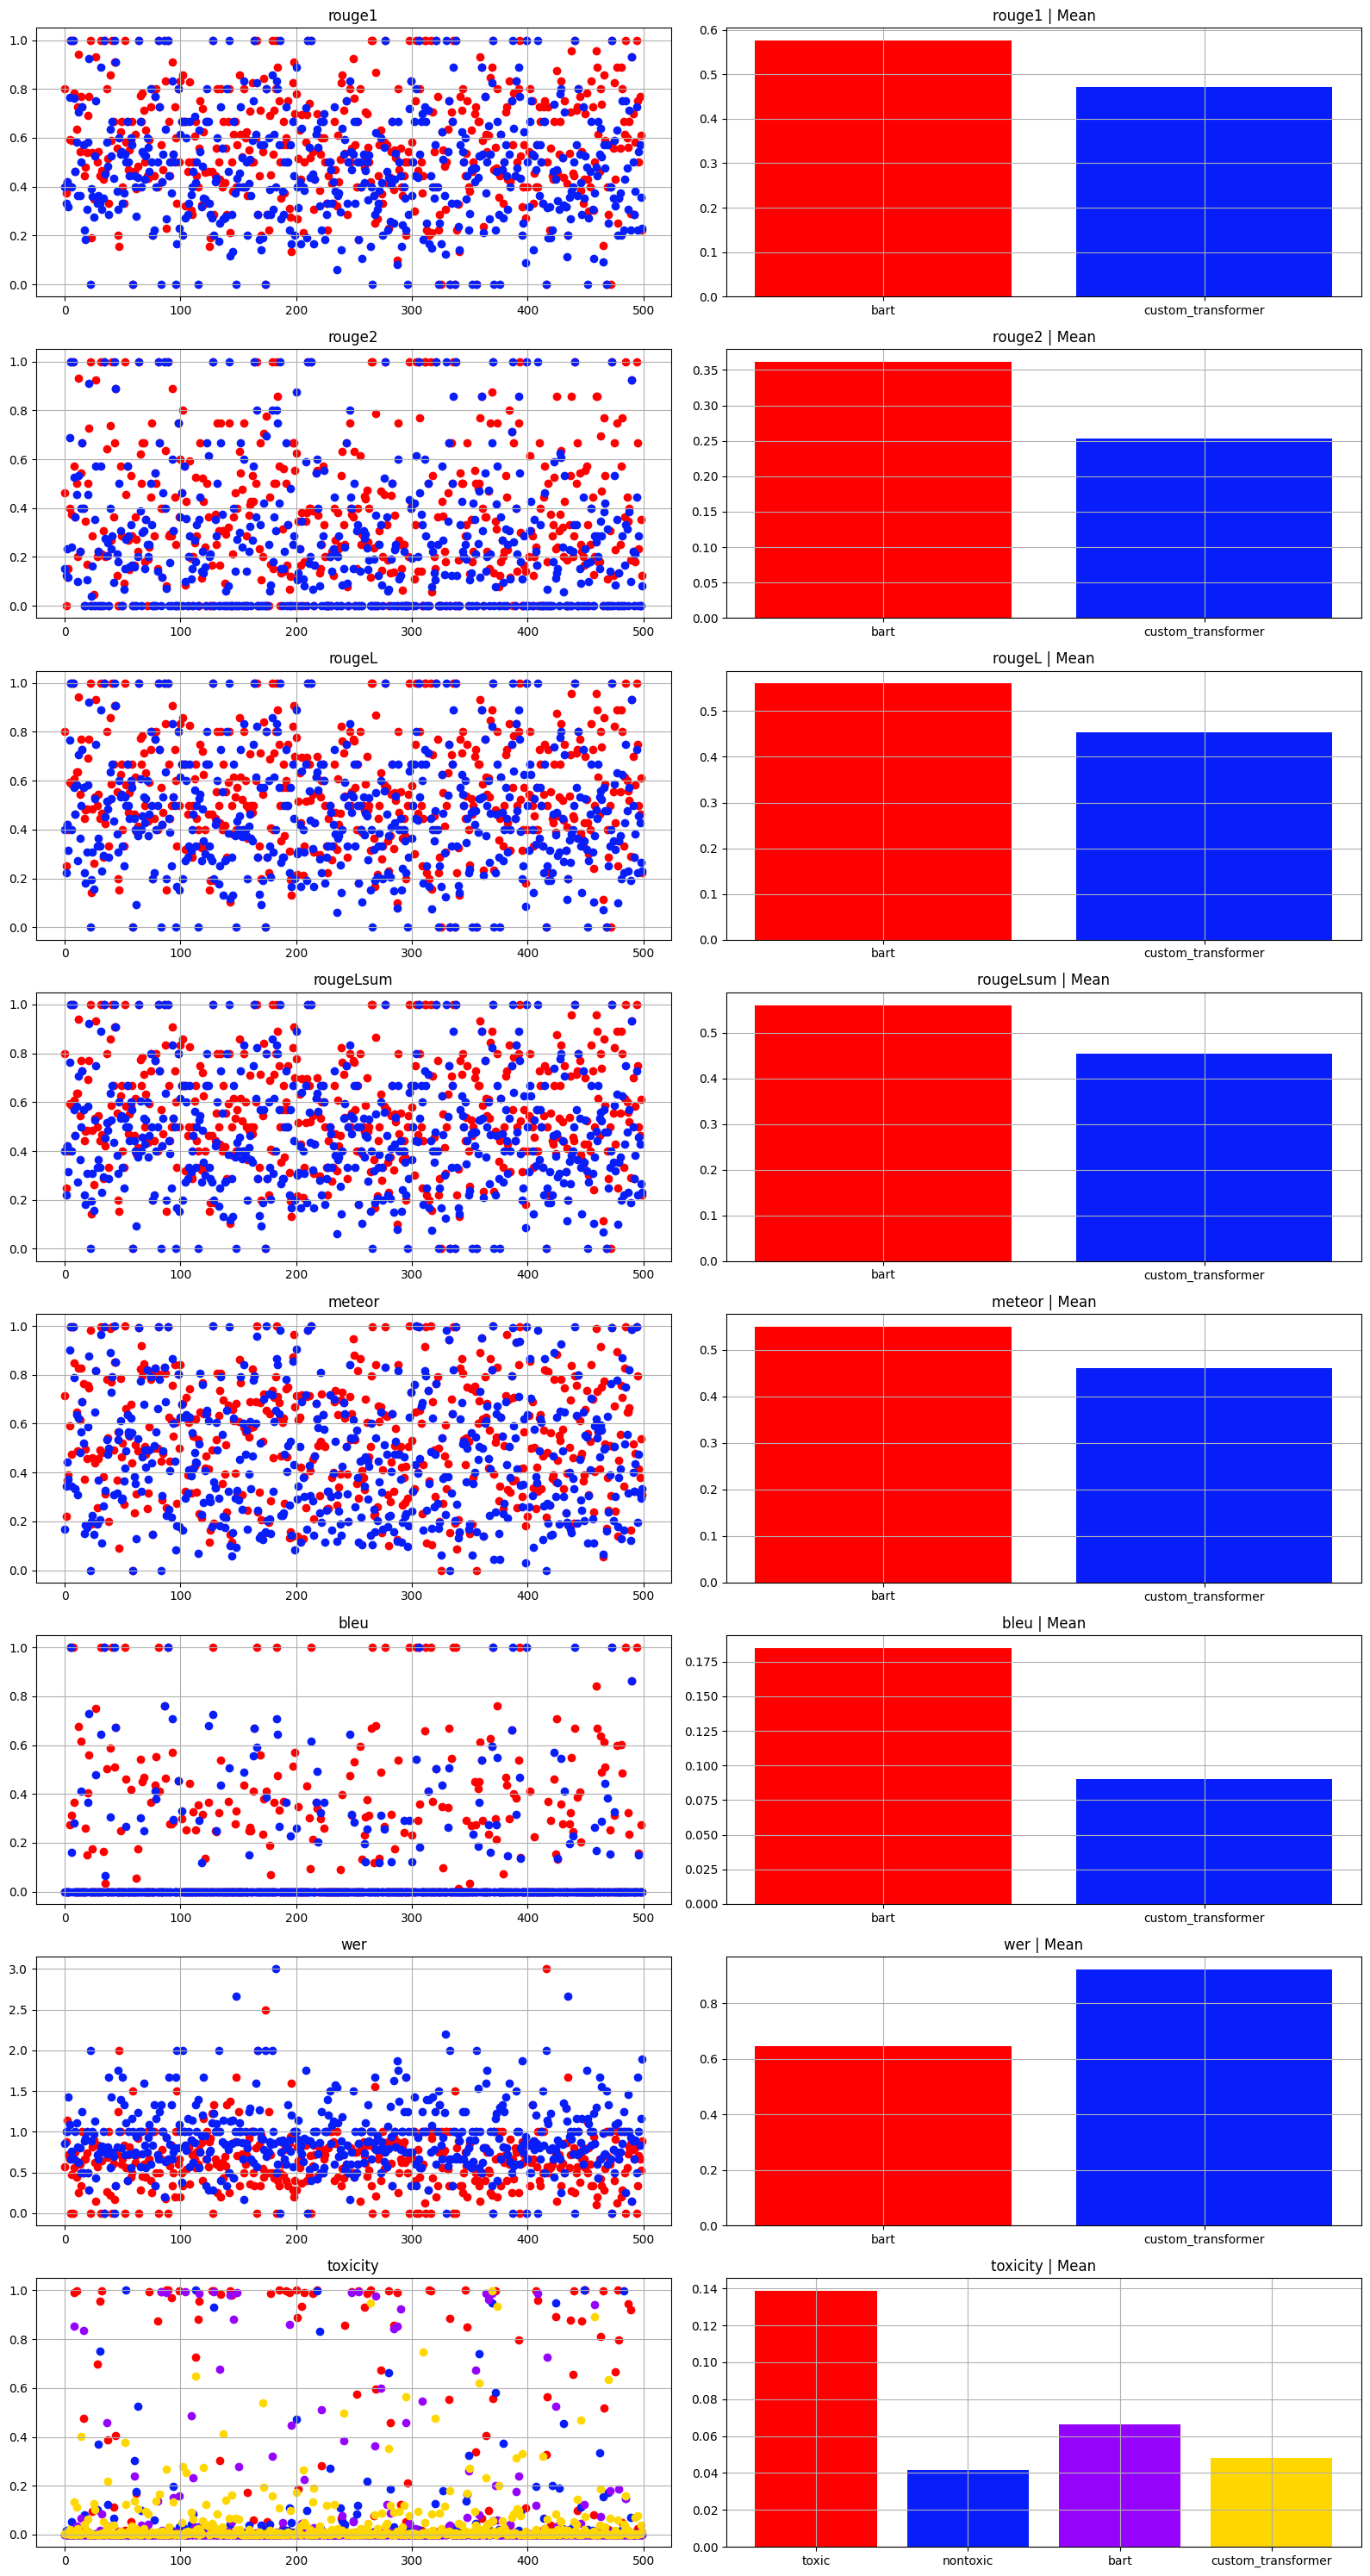

In [145]:
PREDEFINED_COLORS = [
    "#ff0000",
    "#071efb",
    "#9603fd",
    "#ffd700",
    "#00ff00",
    "#04eafc",
]

RELATIVE_METRICS = ["rouge1", "rouge2", "rougeL", "rougeLsum", "meteor", "bleu", "wer"]
RELATIVE_METRICS_COLUMNS = ["bart", "custom_transformer"]
ABSOLUTE_METRICS = ["toxicity"]
ABSOLUTE_METRICS_COLUMNS = ["toxic", "nontoxic", "bart", "custom_transformer"]


def draw_basic_plots(
    df: pd.DataFrame,
    save_path: str,
    round_value: int = 3,
    ylim=None,
    figsize=(16, 30),
):
    plt.clf()
    plt.close()

    colors = PREDEFINED_COLORS

    rows_number = len(RELATIVE_METRICS) + len(ABSOLUTE_METRICS)
    _, axs = plt.subplots(rows_number, 2, figsize=figsize)

    for ax in axs.flat:
        ax.grid()
        ax.set_prop_cycle(color=colors)

    for i in range(rows_number):
        ax1 = axs[i][0]
        ax2 = axs[i][1]

        if i < len(RELATIVE_METRICS):
            metric = RELATIVE_METRICS[i]
            columns = RELATIVE_METRICS_COLUMNS
        else:
            metric = ABSOLUTE_METRICS[i - len(RELATIVE_METRICS)]
            columns = ABSOLUTE_METRICS_COLUMNS

        ax1.set_title(metric)
        ax2.set_title(f"{metric} | Mean")

        mean_values = []
        for column in columns:
            column_name = f"{column}_{metric}"
            rounded = [round(x, round_value) for x in df[column_name]]
            ax1.scatter(range(len(df)), rounded)
            mean_values.append(df[column_name].mean())

        ax2.bar(columns, mean_values, label=columns, color=colors)

    for ax in axs.flat:
        if ylim is not None:
            ax.set_ylim(top=ylim)

    plt.tight_layout()
    plt.savefig(save_path)


draw_basic_plots(df, "../data/figures/basic.svg")

In [139]:
import numpy as np


def draw_difference_plots(
    df: pd.DataFrame,
    save_path: str,
    ylim=None,
    figsize=(16, 30),
):
    plt.clf()
    plt.close()

    colors = PREDEFINED_COLORS

    rows_number = len(RELATIVE_METRICS)
    _, axs = plt.subplots(rows_number, 2, figsize=figsize)

    for ax in axs.flat:
        ax.grid()

    for i in range(rows_number):
        ax1 = axs[i][0]
        ax2 = axs[i][1]

        metric = RELATIVE_METRICS[i]
        columns = RELATIVE_METRICS_COLUMNS

        ax1.set_title(f"{metric} | Difference")
        ax2.set_title(f"{metric} | Percent of maximum")

        differences = df[f"bart_{metric}"] - df[f"custom_transformer_{metric}"]
        ax1.bar(
            range(len(df)),
            differences,
            color=np.where(differences > 0, colors[0], colors[1]),
        )
        bart_maximum_percent = (
            sum(df[f"bart_{metric}"] > df[f"custom_transformer_{metric}"]) / len(df) * 100
        )

        ax2.bar(
            columns,
            [bart_maximum_percent, 100 - bart_maximum_percent],
            label=columns,
            color=colors,
        )

    for ax in axs.flat:
        if ylim is not None:
            ax.set_ylim(top=ylim)

    plt.tight_layout()
    plt.savefig(save_path)

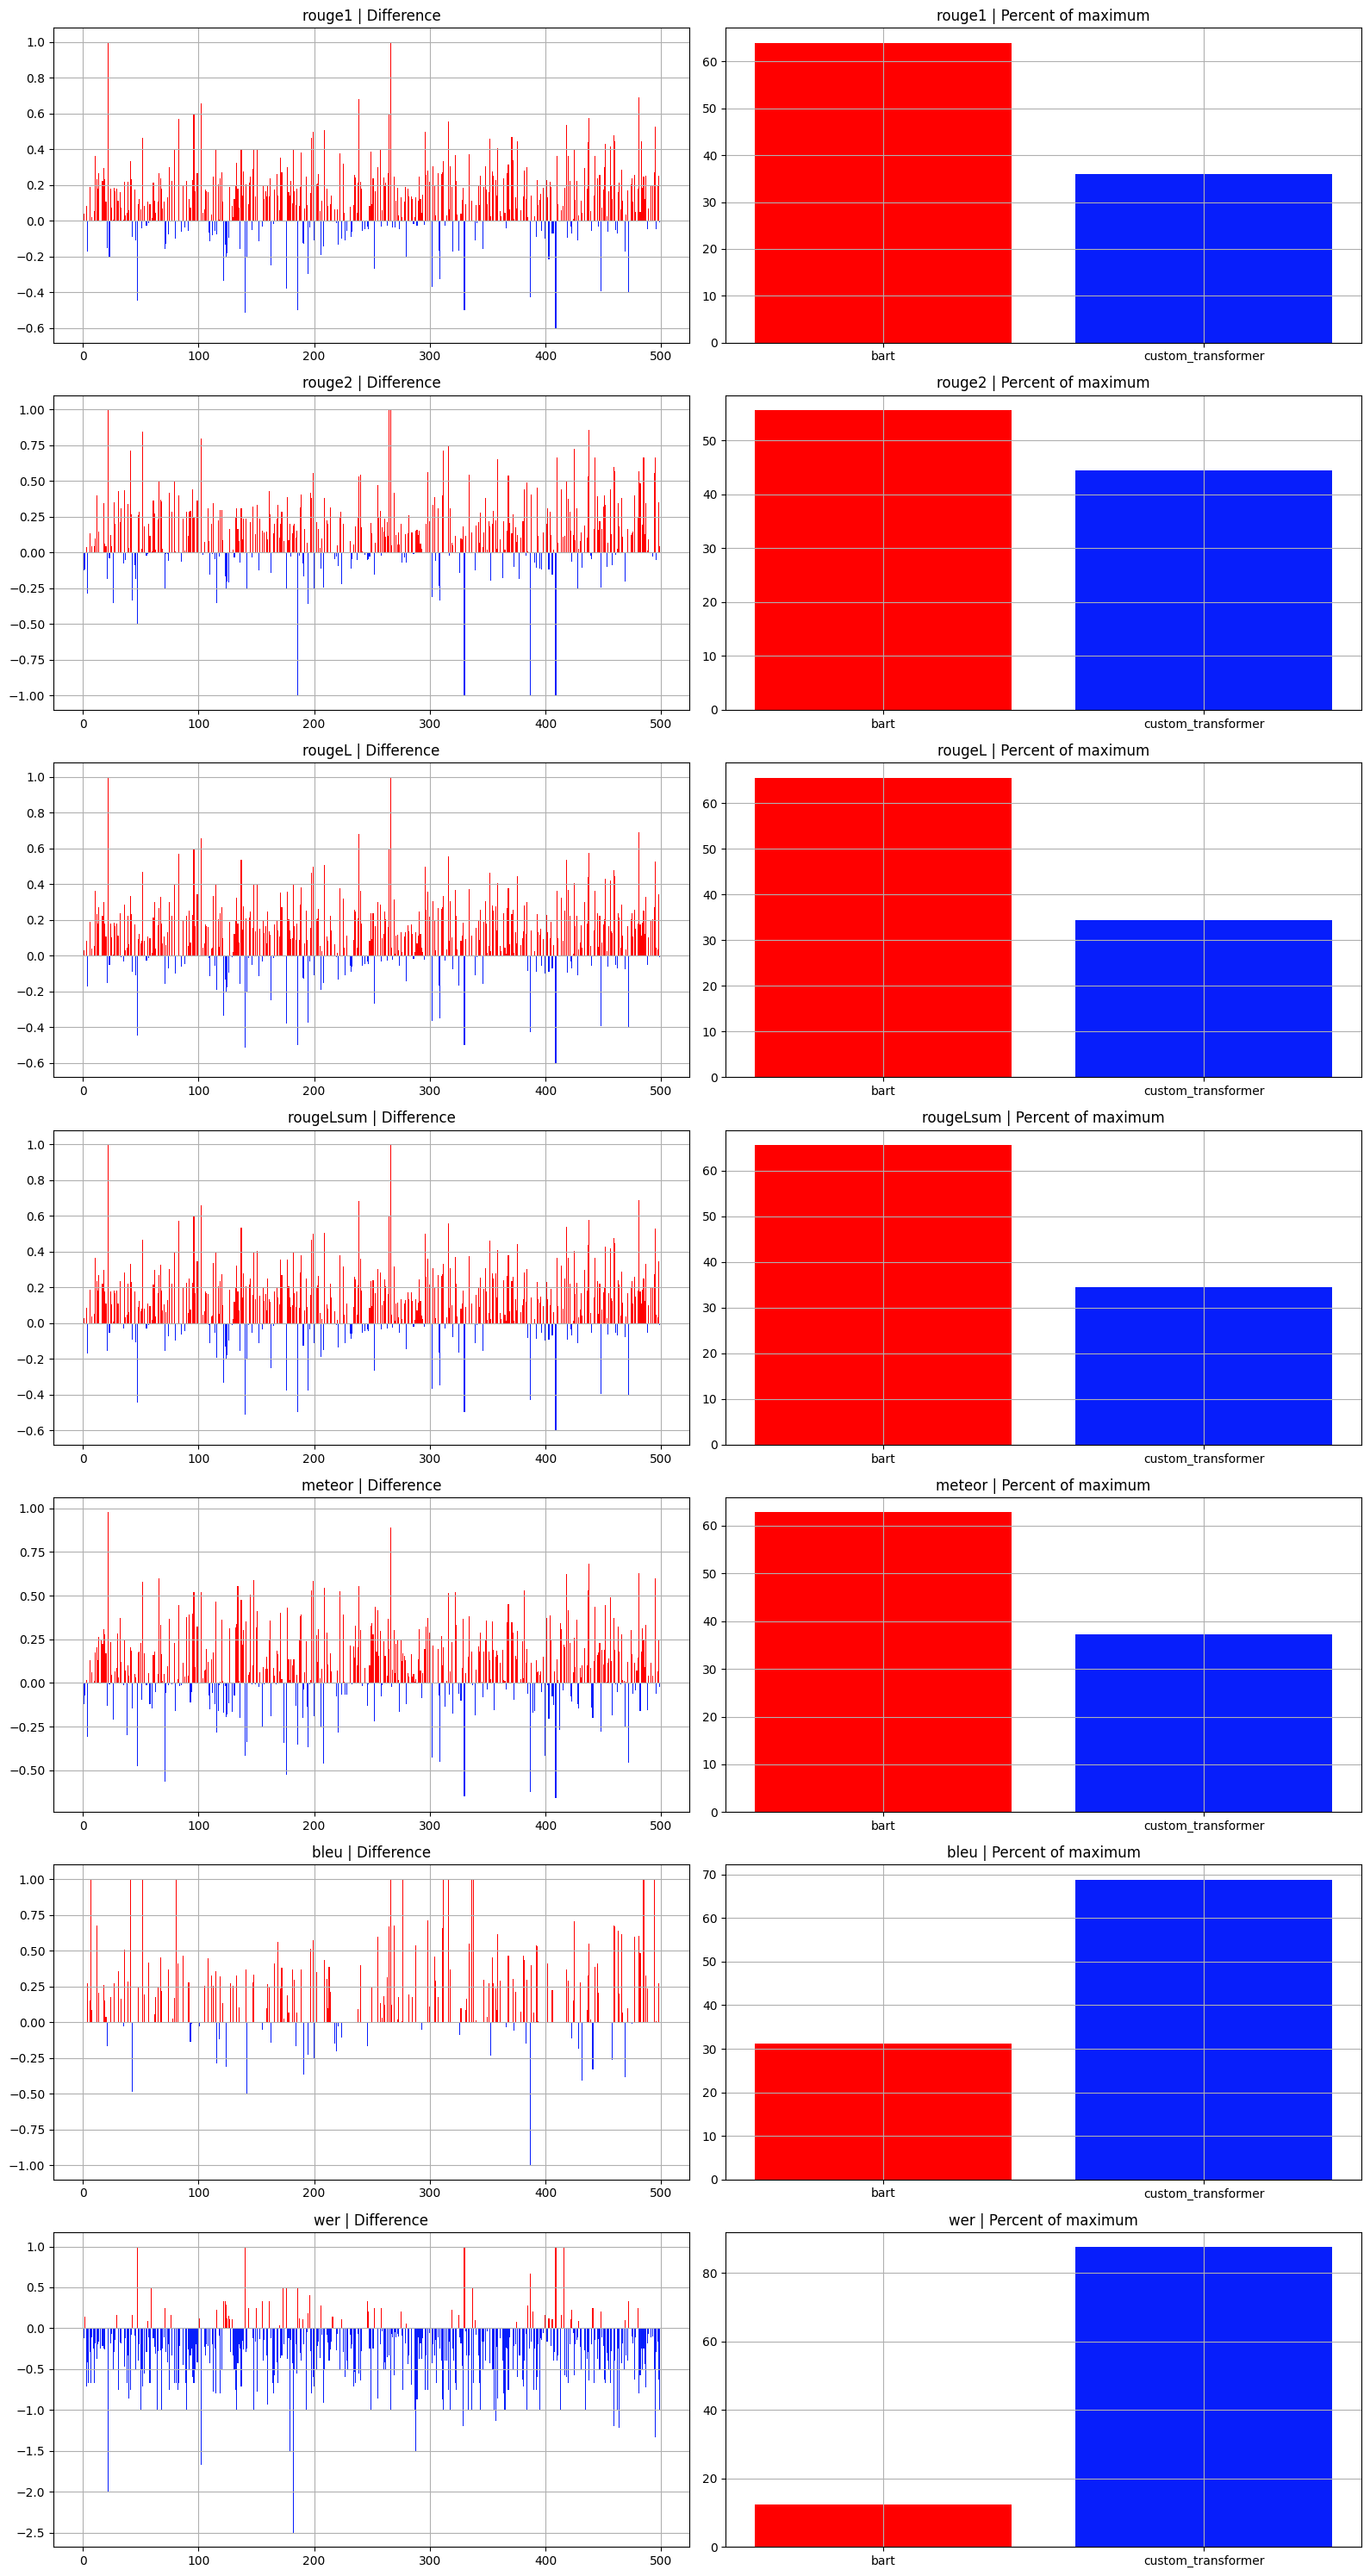

In [140]:
draw_difference_plots(df, "../data/figures/differences.svg")

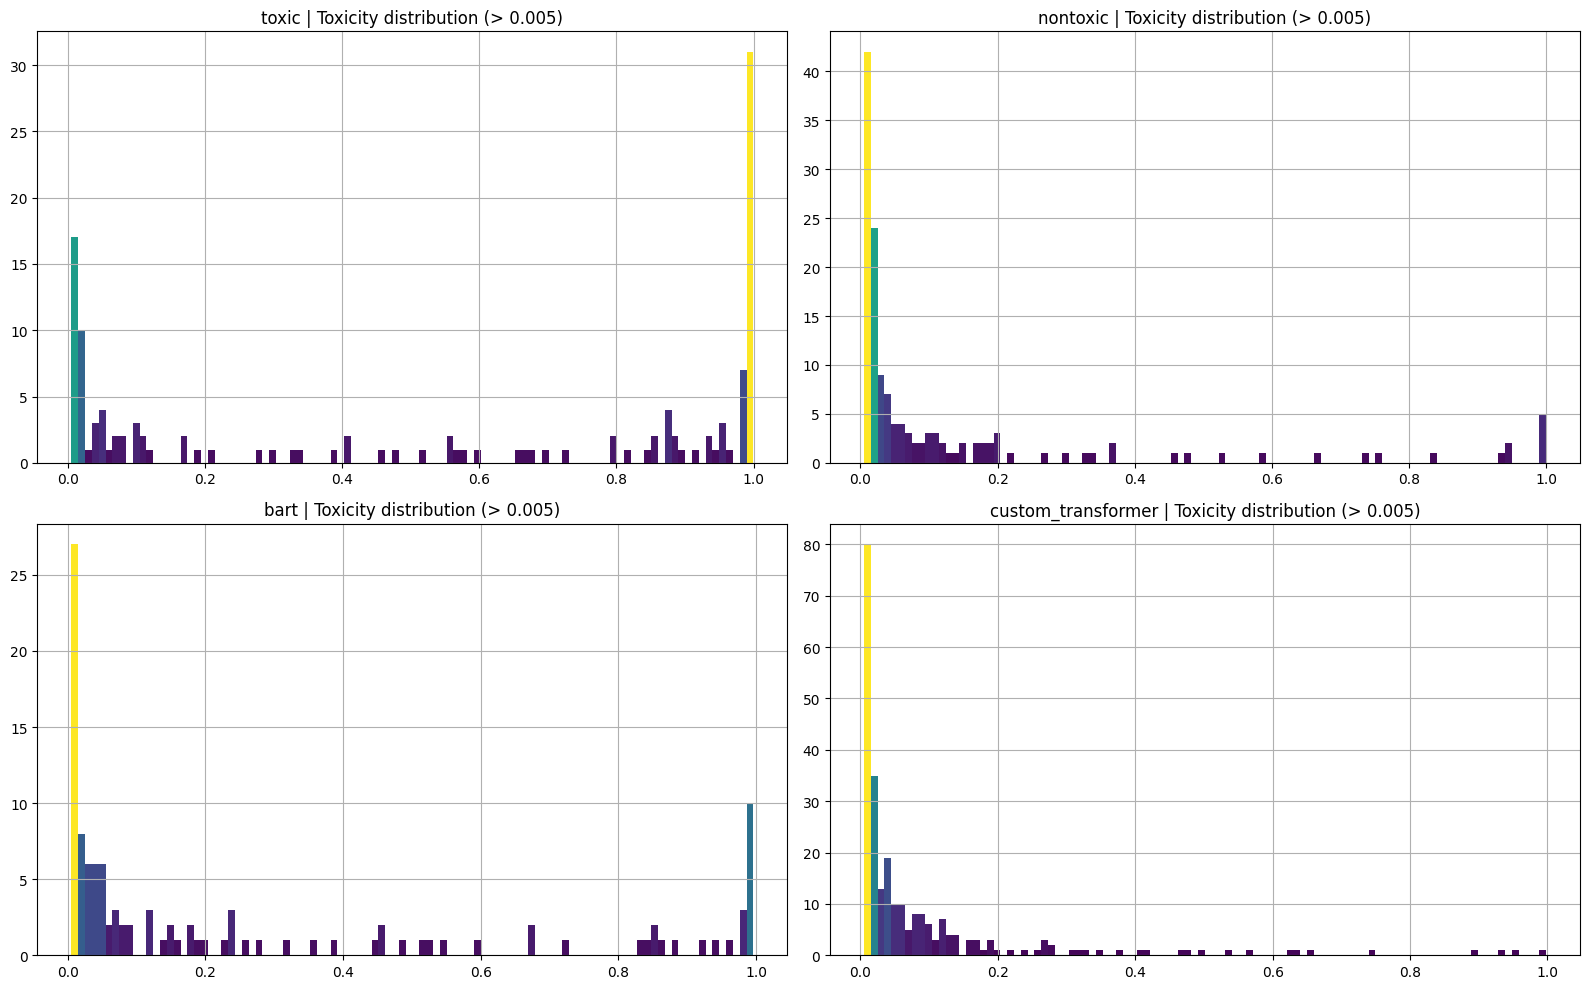

In [138]:
from matplotlib import colors


def draw_toxicity_plots(
    df: pd.DataFrame,
    save_path: str,
    n_bins: int = 100,
    eps: float = 5e-3,
    ylim=None,
    figsize=(16, 10),
):
    plt.clf()
    plt.close()

    _, axs = plt.subplots(2, 2, figsize=figsize)

    for ax in axs.flat:
        ax.grid()

    for i, ax in enumerate(axs.flat):
        column = ABSOLUTE_METRICS_COLUMNS[i]
        ax.set_title(f"{column} | Toxicity distribution (> {eps})")
        data = list(filter(lambda x: x > eps, df[f"{column}_toxicity"]))

        N, _, patches = ax.hist(data, bins=n_bins)
        fracs = N / N.max()
        norm = colors.Normalize(fracs.min(), fracs.max())
        for thisfrac, thispatch in zip(fracs, patches):
            color = plt.cm.viridis(norm(thisfrac))
            thispatch.set_facecolor(color)

    for ax in axs.flat:
        if ylim is not None:
            ax.set_ylim(top=ylim)

    plt.tight_layout()
    plt.savefig(save_path)


draw_toxicity_plots(df, "../data/figures/toxicity.svg")